In [2]:
from skimage import io as skio

import scipy.io
import h5py

from glob import glob

In [15]:
import matlab.engine

In [14]:
from tqdm import tqdm

In [3]:
import numpy as np

In [37]:
from matplotlib import pyplot as plt

In [4]:
from skimage.transform import resize


In [8]:
breeds = [s.split('/')[-1] for s in glob('../CU_dogs/training_133/*')]
breeds.sort()

### Get the all the points for a breed

In [9]:
# for BREED in breeds:

#     breed_mats = glob(f'CU_dogs/training_133/{BREED}/*v4.mat')

#     breed_mats.sort()


#     output = []

#     for name in breed_mats:
#         mat = scipy.io.loadmat(name)

#         img = mat['Icrop']
#         points = mat['parts']

#         scale_W = img.shape[1] / 224
#         scale_H = img.shape[0] / 224

#         points[0] = points[0]/scale_W
#         points[1] = points[1]/scale_H
#         points = np.vstack((points, np.ones(13)))


#         img = resize(img, (224, 224)) * 255
#         img = img.astype(np.uint8)

#         output.append(points)


#     scipy.io.savemat(f"2dpoints/{BREED}_points.mat", {'points':output})

In [48]:
top_breeds = ['005.alaskan_malamute','015.basset_hound','029.border_collie','039.bull_terrier','057.dalmatian','041.bullmastiff','087.irish_terrier','056.dachshund','016.beagle','012.australian_shepherd']

In [10]:
ono = []
for BREED in breeds:
    ono.append(f"2dpoints/{BREED}_points.mat")

In [16]:
eng = matlab.engine.start_matlab()

In [187]:
points_raw_3d = {}
mean_points_2d = {}
motions = {}

In [188]:
errr = ['005.alaskan_malamute']

In [189]:
for BREED in tqdm(errr):
    breed_mats = glob(f'../CU_dogs/training_133/{BREED}/*v4.mat')
    breed_mats.sort()
    
    output = []
    
    total_points = np.zeros((2, 13))
    
    for name in breed_mats:
        mat = scipy.io.loadmat(name)

        img = mat['Icrop']
        points = mat['parts']

        scale_W = img.shape[1] / 224
        scale_H = img.shape[0] / 224

        points[0] = points[0]/scale_W
        points[1] = points[1]/scale_H
        
        total_points += points
        
        points = np.vstack((points, np.ones(13)))
        
        output.append(points.tolist())
        
    mean_points = total_points / len(breed_mats)
    
    mean_points_matlab = matlab.double(mean_points.tolist())
    kps_matlab = matlab.double(output)
    points_3d = eng.get3dPoints(kps_matlab)
    motion, translation = eng.getMotionTranslation(mean_points_matlab, points_3d, 2, nargout = 2)

    points_raw_3d[BREED] = np.array(points_3d)
    mean_points_2d[BREED] = mean_points
    motions[BREED] = [motion, translation]
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


In [190]:
M, T = motions['005.alaskan_malamute']
M, T = np.array(M), np.array(T)

In [191]:
M

array([[ 63.96383757,  -0.76085904,   1.20624819],
       [ -0.09932847, -56.35932663, -30.28238586]])

In [162]:
transformed_S = M @ points_raw_3d['005.alaskan_malamute']

In [163]:
transformed_S = transformed_S + T

In [164]:
transformed_S

array([[ 83.15084538, 139.66403417, 114.19135378,  69.69456745,
        110.74737929, 153.13697599,  73.70609904,  90.14959994,
        131.56045438, 146.72564377, 104.41159221, 121.43166146,
        113.5920433 ],
       [101.04759497, 100.99927369, 148.99898003,  53.31391945,
         45.74615979,  53.12591494,  99.71350976, 103.58195648,
        103.71229817,  99.57438388, 148.77070415, 148.74633969,
        165.01328483]])

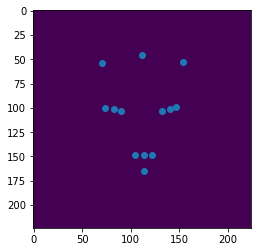

In [137]:
plt.imshow(np.zeros((224, 224)))
plt.scatter(*(mean_points_2d['005.alaskan_malamute']))

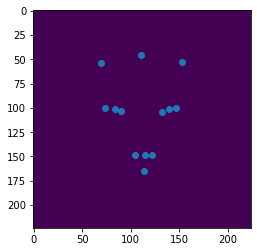

In [138]:
plt.imshow(np.zeros((224, 224)))
plt.scatter(*(transformed_S))

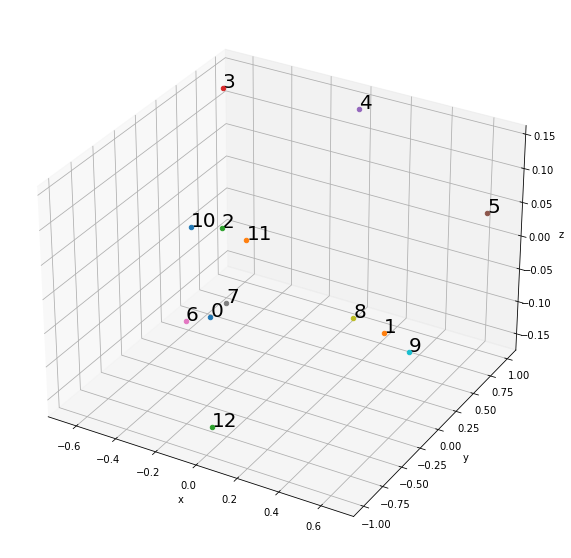

In [167]:
xdata, ydata, zdata = points_raw_3d['005.alaskan_malamute']
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
for i in range(13): #plot each point + it's index as text above
    ax.scatter(xdata[i],ydata[i],zdata[i]) 
    ax.text(xdata[i],ydata[i],zdata[i],  '%s' % (str(i)), size=20, zorder=1,  
    color='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');